In [1]:
import numpy as np
from numba import prange
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable



In [2]:
font = {'size'   : 18}
matplotlib.rc('font', **font)

In [3]:
np.random.seed(1)
nx =1000
x = np.random.random(size=(nx,2))


In [4]:
n_neighbors=15

In [5]:
from tqdm.notebook import tqdm as tq

In [6]:

Exact = np.zeros((nx,nx))
for i in tq(prange(nx-1)):
    for j in prange(i+1,nx):
        Exact[i,j]=Exact[j,i]=np.linalg.norm(x[i]-x[j])

In [7]:
import annchor

In [8]:
import time

In [15]:
start=time.time()
ann = annchor.Annchor(x,lambda x,y:np.linalg.norm(x-y),
                      n_anchors=10,
                      n_neighbors=15,
                      min_prob=0.1,
                      random_seed=1,
                      partitions=4,n_samples=4000)
ann.fit()
print(time.time()-start)

min_prob reduced to 0.021898
3.6564810276031494


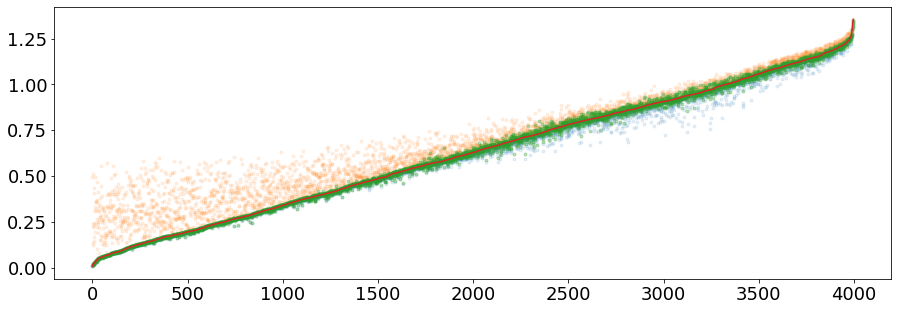

In [16]:
fig,ax = plt.subplots(figsize=(15,5))
ig = np.argsort(ann.G[:,2])
ax.plot(ann.G[ig,:2],'.',alpha=0.1)
#from sklearn.ensemble import RandomForestRegressor as RFR

ax.plot(ann.LR.predict(ann.G[ig,:2],ann.GF),'.',alpha=0.3)
ax.plot(ann.G[ig,2])
plt.show()





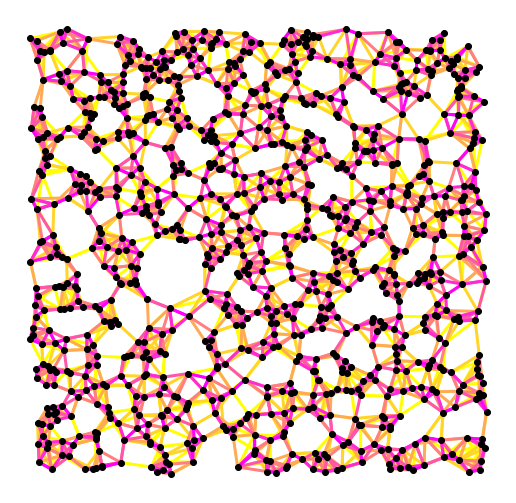

In [17]:

from tqdm.notebook import tqdm as tq
fig,ax = plt.subplots(figsize=(9,9))
ax.plot(*x.T,'o',color='k')
ax.axis('off')
k=7
for j in tq(range(k)):
    U = x[np.arange(nx)]
    V = x[ann.neighbor_graph[0][:,j+1]]
    for u,v in zip(U,V):
        ax.plot(*np.vstack([u,v]).T,color=plt.cm.spring(j/(k-1)),zorder=-j,linewidth=3)
plt.show()

In [18]:
ann.evals

23718

In [19]:
neighbors = ann.get_ann()
exact_set = {i:set(np.argsort(Exact[i])[:15]) for i in (range(nx))}


anchor_set = {i:set(neighbors[0][i]) for i in (range(nx))}
acc = [(len(anchor_set[i].intersection(exact_set[i]))) for i in range(nx)]


np.sum(acc)/15000

0.9997333333333334

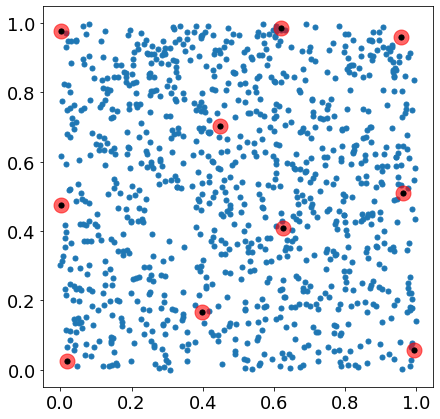

In [20]:
# View the anchor points

fig,ax = plt.subplots(figsize=(7,7))

ax.plot(*x.T,'o',markersize=5)

ax.plot(*x[ann.A].T,'or',markersize=15,alpha=0.6)
ax.plot(*x[ann.A].T,'ok',markersize=5)


plt.show()

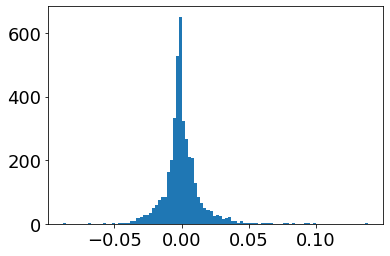

In [23]:
exact = ann.G[:,2]
widths = (ann.G[:,1]-ann.G[:,0])
approx = ann.LR.predict(ann.G[:,:2],ann.GF)
ub = ann.G[:,1].copy()
lb = ann.G[:,0].copy()


widths-=np.min(widths)
approx-=np.min(approx)
widths/=np.max(widths)
approx/=np.max(approx)

lb-=np.min(lb)
ub-=np.min(ub)
lb/=np.max(lb)
ub/=np.max(ub)

exact = ann.G[:,2]
diff = exact-ann.LR.predict(ann.G[:,:2],ann.GF)
fig,ax = plt.subplots()
ax.hist(diff,bins=100)
plt.show()

In [16]:
widths

array([0.32877715, 0.09407711, 0.04346076, ..., 0.00526925, 0.10618146,
       0.18956914])

Text(0.5, 1.0, 'ideal partition')

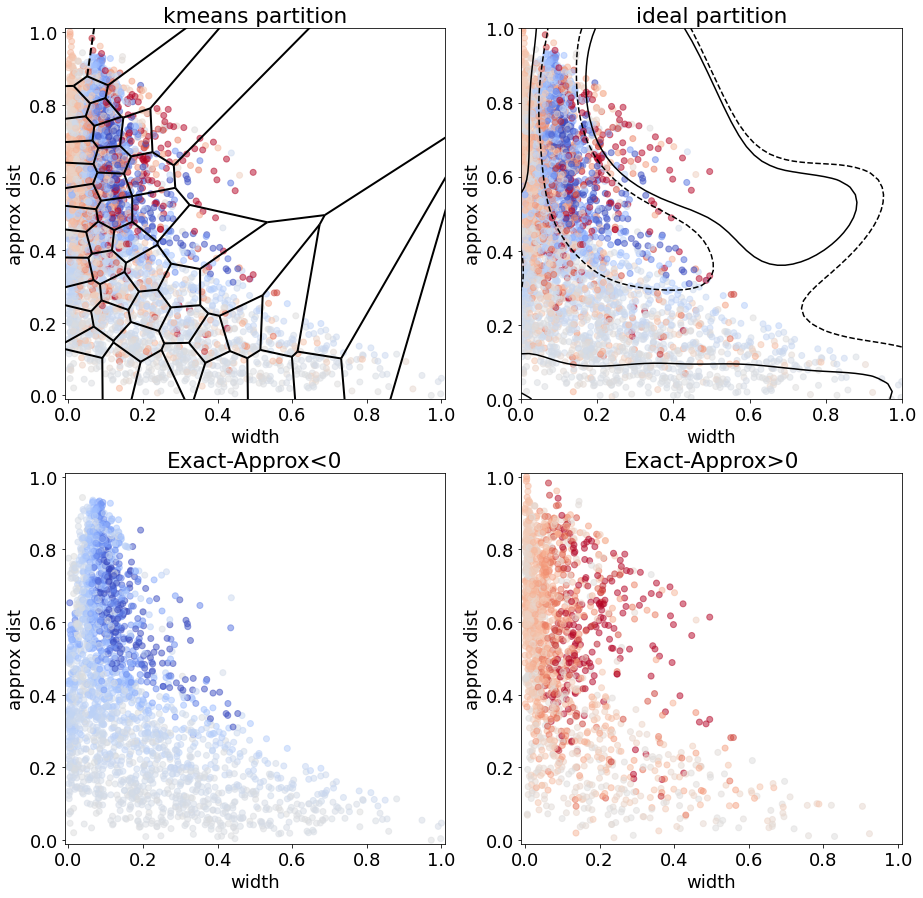

In [24]:
ndiff = diff-np.min(diff)
ndiff/=np.max(ndiff)
fig,axs = plt.subplots(2,2,figsize=(15,15))
axs=axs.flatten()
mask=diff<0
cmap = plt.cm.coolwarm
ndist=diff.copy()
ndist-=np.min(ndist)
ndist/=np.max(ndist)
axs[0].scatter(widths,
               approx,
               c=diff,
               vmin=-0.025,
               vmax=0.025,
               cmap=cmap,
              alpha=0.5)
axs[0].set_title('kmeans partition')


axs[2].scatter(widths[mask],
               approx[mask],
               c=diff[mask],
               vmin=-0.025,
               vmax=0.025,
               cmap=cmap,alpha=0.5)
axs[2].set_title('Exact-Approx<0')
axs[3].scatter(widths[~mask],
               approx[~mask],
               c=diff[~mask],
               vmin=-0.025,
               vmax=0.025,
               cmap=cmap,alpha=0.5)
axs[3].set_title('Exact-Approx>0')


from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=50)
labels = kmeans.fit_predict(np.array([widths,approx]).T)
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(kmeans.cluster_centers_[:,:2])

voronoi_plot_2d(vor, show_vertices=False,show_points=False,
                line_width=2, point_size=15,ax=axs[0],color='k')

for ax in axs:
    ax.set_xlim(-0.01,1.01)
    ax.set_ylim(-0.01,1.01)
    ax.set_xlabel('width')
    ax.set_ylabel('approx dist')
    
    

    
np.vstack([widths,approx,diff])
from sklearn.svm import NuSVR
rf=NuSVR(kernel='rbf')
d = np.vstack([widths,approx]).T
rf.fit(np.vstack([widths,approx]).T,diff)

x = np.linspace(0,1,50)
y = np.linspace(0,1,50)
X,Y = np.meshgrid(x,y)
Z = np.zeros(shape=X.shape)
p = np.vstack([X.flatten(),Y.flatten()]).T
#ax.contourf(X,
#           Y,
#           rf.predict(p).reshape(50,50),
#           vmin=-0.025,
#           vmax=0.025,
#           cmap=cmap,
#           levels=1000)
axs[1].contour(X,
           Y,
           rf.predict(p).reshape(50,50),
           colors='k',
           levels=[-0.0025,0.0025])
axs[1].scatter(widths,
               approx,
               c=diff,
               vmin=-0.025,
               vmax=0.025,
               cmap=cmap,
              alpha=0.5)
axs[1].set_xlim(0,1)
axs[1].set_ylim(0,1)
axs[1].set_title('ideal partition')



In [25]:
labels = kmeans.labels_.copy()

for it in tq(range(40)):
    slabels=np.sort(list(set(labels)))
    def minmax(f):
        g = np.array(f).astype(float)
        g-=np.min(g)
        g/=np.max(g)
        return g

    ms = minmax([np.mean(diff[labels==i])for i in slabels])
    vs = minmax([np.var(diff[labels==i])for i in slabels])
    ls = minmax([len(diff[labels==i])for i in slabels])

    ws = np.array([np.mean(widths[labels==i])for i in slabels])
    As = np.array([np.mean(approx[labels==i])for i in slabels])
    
    dls = np.vstack([ms,ws,As]).T
    n=dls.shape[0]
    b = 10000
    i = np.argmin(ls)#[np.random.randint(5)]

    for j in slabels:
        if i!=j:
            dist = np.linalg.norm(dls[i]-dls[j])#*np.min([ls[i],ls[j]])**2
            if dist<b:
                ib,jb = np.sort([i,j])
                b=dist

    labels[labels==ib]=jb
    if ib<len(slabels)-1:
        labels[labels==np.max(labels)]=ib
    #print(ib,jb,max(slabels))

In [26]:
labels

array([3, 6, 3, ..., 9, 9, 9], dtype=int32)

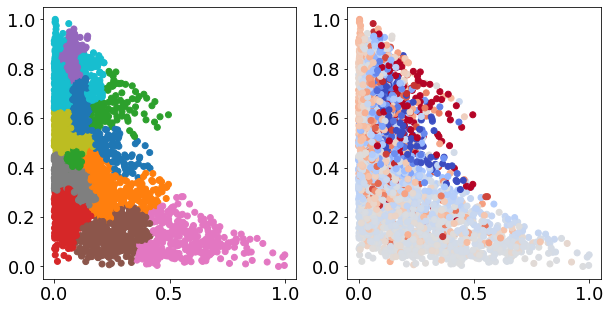

In [27]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
axs=axs.flatten()
axs[0].scatter(widths,
          approx,
          c=labels,
          cmap=plt.cm.tab10,vmin=0,vmax=10)
axs[1].scatter(widths,
          approx,
          c=diff,
          cmap=cmap,
          vmin=-0.025,
          vmax=0.025)
plt.show()

(-0.05, 0.02)

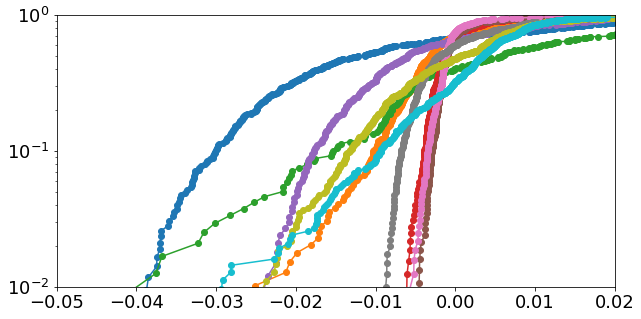

In [29]:
fig,ax = plt.subplots(figsize=(10,5))
for i in range(10):
    h = np.sort(diff[labels==i])
    ax.plot(h,np.linspace(0,1,len(h)),'-o')
ax.set_yscale('log')
ax.set_ylim(0.01,1)
ax.set_xlim(-0.05,0.02)